In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

from scipy.optimize import minimize
from scipy.integrate import solve_ivp
from scipy.interpolate import approximate_taylor_polynomial

In [4]:
from numpy import sqrt, sin, cos, log, pi, e

In [5]:
plt.style.use([
    'notebook',
    'grid',
    'nature',
    'science',
    {'figure.dpi': 150}
])

In [6]:
# dados simulacao

r = .31
mu = .4
sigma = .55
a4 = .3019

In [7]:
# dSdt

def dSdt(t, s, u, a_1, a_2, a_3, b_1, b_2, b_3):
    h3, h4 = s

    if h3 < 0:
        h3 = 0
    
    q_out = (a_1 * sqrt(h3) + b_1) * 10e-5
    q_in = (a_2 * u + b_2) * 10e-5
    q_com = (a_3*(h4 - h3) + b_3) * 10e-4

    z = 2.5*np.pi*((h3-8)/100) - mu
    w = -((((h3-8)/100)-mu)**2)/(2*sigma**2)

    taylor_z = (1 - (z**2/2) + (z**4/24) - (z**6/720) + (z**8/40320))
    taylor_w = (1 + w + (w**2/2) + (w**3/6) + (w**4/24))

    a3 = (3*r/5)*(2.7*r - (1/(6*sqrt(2*pi)))*taylor_z*taylor_w)

    h3_dot = (q_com - q_out) / a3
    h4_dot = (q_in - q_com) / a4

    return [h3_dot, h4_dot]

In [8]:
def simulate(s_0, coefficients, sim_time, sim_step, samples, control_signal):
    time = np.linspace(sim_time[0], sim_time[1], samples)
    time_span = [time[0], time[-1]]

    args = [control_signal]
    args = args + [coefficients[i] for i in range(len(coefficients))]

    s = solve_ivp(
        dSdt,
        y0=s_0,
        args=args,
        t_span=time_span,
        t_eval=time,
    )

    return s

In [9]:
sim_steps = np.array([
    .14399262757751785,
    .18905021173623027,
    .2779012894616244,
    .2925345190742519,
    .39301996541507833
])

sim_control_signals = np.array([75, 50, 60, 90, 75])

def multiple_inputs_simulation(coefficients):
    s_0 = [0, 0]
    sim_time = [0, 2500]
    samples = 10798

    solutions = []

    last_s = s_0
    last_t = sim_time

    for i in range(len(sim_steps)):
        s = simulate(
            last_s,
            coefficients,
            last_t,
            sim_steps[i], 
            samples,
            sim_control_signals[i]
        )

        last_s = s.y[:,-1]
        last_t = [last_t[-1], last_t[-1] + 2500]

        solutions.append(s)


    return solutions

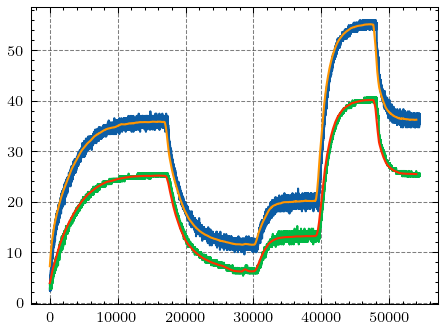

In [10]:
real_time = np.load('./data/time.npy')
level3 = np.load('./data/level3.npy')
level4 = np.load('./data/level4.npy')

# removing the noise using moving average
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


filtered_level3 = moving_average(level3, n=500)
filtered_level4 = moving_average(level4, n=500)

plt.plot(level3)
plt.plot(level4)

plt.plot(filtered_level3, label='h3')
plt.plot(filtered_level4, label='h3')

In [11]:
solutions = multiple_inputs_simulation(
    [132.99999793, 12.4600019, 450.97000535, -808.49000125, -940.92999958, 5000.1200015]
)

y = np.hstack([s.y for s in solutions])
t = np.hstack([s.t for s in solutions])

h3 = y[0, :]
h4 = y[1, :]

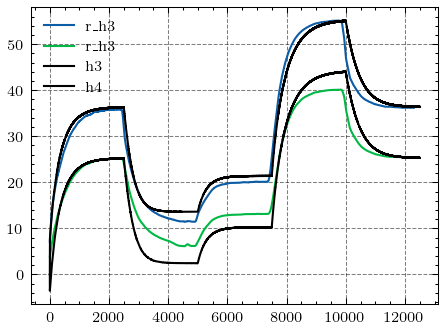

In [12]:
plt.plot(real_time[:-499], filtered_level3, label='r_h3')
plt.plot(real_time[:-499], filtered_level4, label='r_h3')

plt.plot(t, h3, label='h3', color='black')
plt.plot(t, h4, label='h4', color='black')

plt.legend()